In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm
from sklearn.utils import check_random_state

from dataset import SyntheticSlateBanditDataset
from policy import gen_eps_greedy
from estimator import SlateInversePropensityScore as IPS
from util import SlateOffPolicyEvaluation, aggregate_simulation_results, visualize_mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# setting 1

# 変数
n_actions_list=[3,4,5,6]

# 定数
behavior_ratio = {"independent": 0.3, "cascade": 0.4, "all": 0.3}
data_size=300
n_sim=80
dim_context=5
len_list=3
alpha = np.ones(len_list)
eps=0.5
return_pscore={"all": True, "independent": True, "cascade": True, "adaptive": False}
estimator_to_pscore_dict={"SIPS": "all", "IIPS": "independent", "RIPS": "cascade"}

In [12]:
result_df_list = []
for n_actions in n_actions_list:
    result_dict = defaultdict(list)
    for seed in tqdm(range(n_sim), desc=f"n_actions={n_actions}..."):
        

        # generate synthetic data
        dataset = SyntheticSlateBanditDataset(
            n_unique_action=n_actions,
            len_list=len_list,
            dim_context=dim_context,
            behavior_ratio=behavior_ratio,
            random_state=seed,
        )
        data = dataset.obtain_batch_bandit_feedback(n_rounds=data_size, return_pscore=return_pscore)
        expected_reward_factual = data["expected_reward"][np.arange(data_size), data["user_behavior_id"]]

        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps)
        _, evaluation_policy_pscore = dataset.aggregate_propensity_score(
            ranking_pi=evaluation_policy, 
            slate_id=data["slate_id"],
            user_behavior=data["user_behavior"],
            return_pscore=return_pscore,
        )
        
        for estimator_name, pscore_name in estimator_to_pscore_dict.items():
            if pscore_name == "all":
                weight_max = (evaluation_policy_pscore[pscore_name] / data["pscore"][pscore_name])[:,0].max()
            else:
                weight_max  = (evaluation_policy_pscore[pscore_name] / data["pscore"][pscore_name]).max(0).mean()
                
            result_dict[estimator_name].append(weight_max)
    
    # calculate expected weight_max
    result_dict = dict(zip(result_dict.keys(), map(np.mean, result_dict.values())))
    result_df = DataFrame({
        "estimator": result_dict.keys(), "weight_max": result_dict.values(), "n_actions": n_actions
    })
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

n_actions=3...: 100% 80/80 [01:03<00:00,  1.26it/s]
n_actions=4...: 100% 80/80 [01:13<00:00,  1.09it/s]
n_actions=5...: 100% 80/80 [01:29<00:00,  1.11s/it]
n_actions=6...: 100% 80/80 [01:56<00:00,  1.46s/it]


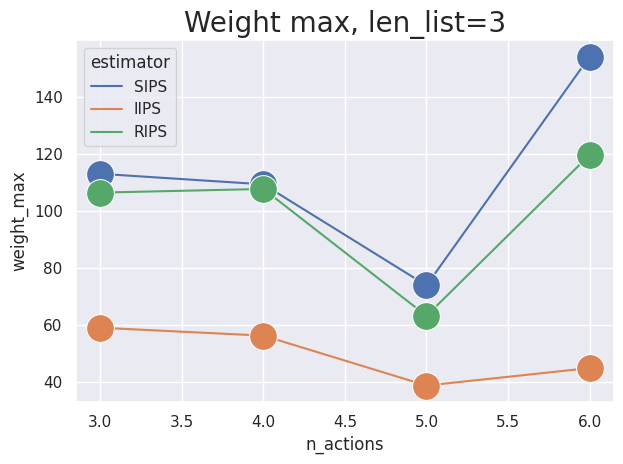

In [13]:
sns.lineplot(
    data=result_df,
    hue="estimator",
    x="n_actions",
    y="weight_max",
    marker="o",
    ci=None,
    markersize=20,

)
plt.title(f'Weight max, len_list={len_list}', fontsize=20)
plt.tight_layout()
plt.show()

In [5]:
# setting 2

# 変数
len_list_list=[3, 4, 5, 6]

# 定数
behavior_ratio = {"independent": 0.3, "cascade": 0.4, "all": 0.3}
data_size=300
n_sim=10
dim_context=5
n_actions=7
alpha = np.ones(len_list)
eps=0.5
return_pscore={"all": True, "independent": True, "cascade": True, "adaptive": False}
estimator_to_pscore_dict={"SIPS": "all", "IIPS": "independent", "RIPS": "cascade"}

In [ ]:
result_df_list = []
for len_list in len_list_list:
    result_dict = defaultdict(list)
    for seed in tqdm(range(n_sim), desc=f"len_list={len_list}..."):
        

        # generate synthetic data
        dataset = SyntheticSlateBanditDataset(
            n_unique_action=n_actions,
            len_list=len_list,
            dim_context=dim_context,
            behavior_ratio=behavior_ratio,
            random_state=seed,
        )
        data = dataset.obtain_batch_bandit_feedback(n_rounds=data_size, return_pscore=return_pscore)
        expected_reward_factual = data["expected_reward"][np.arange(data_size), data["user_behavior_id"]]

        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps)
        _, evaluation_policy_pscore = dataset.aggregate_propensity_score(
            ranking_pi=evaluation_policy, 
            slate_id=data["slate_id"],
            user_behavior=data["user_behavior"],
            return_pscore=return_pscore,
        )
        
        for estimator_name, pscore_name in estimator_to_pscore_dict.items():
            if pscore_name == "all":
                weight_max = (evaluation_policy_pscore[pscore_name] / data["pscore"][pscore_name])[:,0].max()
            else:
                weight_max  = (evaluation_policy_pscore[pscore_name] / data["pscore"][pscore_name]).max(1).mean()
                
            result_dict[estimator_name].append(weight_max)
    
    # calculate expected weight_max
    result_dict = dict(zip(result_dict.keys(), map(np.mean, result_dict.values())))
    result_df = DataFrame({
        "estimator": result_dict.keys(), "weight_max": result_dict.values(), "len_list": len_list
    })
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

len_list=3...: 100% 10/10 [00:27<00:00,  2.79s/it]
len_list=4...: 100% 10/10 [01:46<00:00, 10.62s/it]
len_list=5...: 100% 10/10 [12:15<00:00, 73.51s/it]
len_list=6...:   0% 0/10 [00:00<?, ?it/s]

In [ ]:
sns.lineplot(
    data=result_df,
    hue="estimator",
    x="len_list",
    y="weight_max",
    marker="o",
    ci=None,
    markersize=20,

)
plt.title(f'Weight max, n_actions={n_actions}', fontsize=20)
plt.tight_layout()
plt.show()